In [1]:
import pandas as pd

Наши новости

In [2]:
news = pd.read_csv("articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


Загрузим пользователей и списки последних прочитанных новостей

In [3]:
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


Итак, нам нужно получить векторные представления пользователей на основе прочитанным ими новостей и самих новостей

### 1. Получаем векторные представления новостей

In [4]:
!pip install gensim

In [5]:
!pip install nltk

In [6]:
!pip install razdel

In [7]:
!pip install pymorphy2

In [8]:
#from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

C:\ProgramData\Anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [9]:
#предобработка текстов
import re
import numpy as np
import nltk
from nltk.corpus import stopwords
#from nltk.tokenize import word_tokenize

from razdel import tokenize # https://github.com/natasha/razdel
#!pip install razdel

import pymorphy2  # pip install pymorphy2

In [10]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kto-k\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [11]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

In [12]:
with open('stopwords.txt', encoding='UTF-8') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [13]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [14]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

<ipython-input-13-7ee348d9b386>:15: FutureWarning: Possible nested set at position 39
  text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)


Wall time: 24.9 s


In [15]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

Wall time: 3min 22s


А теперь в 3 строчки обучим нашу модель

In [16]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

Что такое common_dictionary и как он выглядит

In [17]:
common_dictionary[10]

'ватутин'

Все просто - это словарь наших слов

Запускаем обучение

In [18]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

Wall time: 29.9 s


In [19]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

Обучили модель. Теперь 2 вопроса:

1. как выглядят наши темы
2. как получить для документа вектор значений (вероятности принадлежности каждой теме)

In [20]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'играть', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'хороший']


[(7, 0.057642143),
 (9, 0.30952266),
 (11, 0.284032),
 (13, 0.14677052),
 (18, 0.18117923)]

In [21]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: млрд млн рубль рост фонд составить цена
topic_1: сша россия путин российский рак глава владимир
topic_2: исследование вирус отряд край треть продолжительность компьютерный
topic_3: ракета продукция запуск памятник технология фсб блок
topic_4: научный развитие проект министр программа правительство японский
topic_5: исследование пациент остров испытание солнце высота китай
topic_6: смерть место первый британский великобритания болезнь организм
topic_7: nn москва убийство фестиваль русский статья nnn
topic_8: россия российский система банк nn новый вопрос
topic_9: газ украина температура украинский всё россия законодательство
topic_10: день nn земля вода всё жизнь университет
topic_11: превысить мышь виза ндс кость соцсеть льгота
topic_12: взрыв работник производить оплата земля катастрофа произойти
topic_13: всё мужчина способность погода очень ребёнок физика
topic_14: операция египет армия одежда страдать подросток ввс
topic_15: офицер бизнесмен фрагмент лечение звонок куба уб

Очень неплохо - большинство тем вполне можно описать о чем они

Давайте напишем функцию, которая будет нам возвращать векторное представление новости

In [22]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [23]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.000000,0.0,0.016595,0.363727,0.118290,0.0,0.015513,0.180641,0.208926,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,4896,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.095399,0.053579,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,4897,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.057678,0.000000,...,0.0,0.000000,0.0,0.180939,0.0,0.0,0.0,0.0,0.0,0.0
3,4898,0.280694,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.041999,0.000000,...,0.0,0.049954,0.0,0.287011,0.0,0.0,0.0,0.0,0.0,0.0
4,4899,0.000000,0.0,0.325216,0.000000,0.387537,0.0,0.000000,0.116670,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


Прекрасно, мы получили вектора наших новостей! И даже умеем интерпретировать получившиеся темы.

Можно двигаться далее

### Следующий шаг - векторные представления пользователей

In [24]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [25]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [26]:
doc_dict[293622]

array([0.        , 0.07288264, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.06109616, 0.        , 0.03668101,
       0.41580635, 0.        , 0.        , 0.03365441, 0.        ,
       0.        , 0.11867117, 0.        , 0.        , 0.        ,
       0.        , 0.0670898 , 0.182578  , 0.        , 0.        ])

In [27]:
user_articles_list = users['articles'].iloc[33]



In [31]:
def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector

In [32]:
get_user_embedding(user_articles_list)

array([0.00684141, 0.18617246, 0.        , 0.00764506, 0.00932617,
       0.00950115, 0.00611711, 0.09376815, 0.25909054, 0.07487512,
       0.05062385, 0.        , 0.        , 0.0261667 , 0.00866552,
       0.0042558 , 0.04650527, 0.        , 0.02444917, 0.00815125,
       0.        , 0.04178028, 0.05101431, 0.07163528, 0.00316166])

Интересовался новостями с топиками topic_3, topic_14 (что-то про политику и государство)

In [33]:
#users['articles'].iloc[33]

In [34]:
#" ".join(news[news['doc_id']==323186]['title'].iloc[0])

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [35]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.051953,0.020623,0.017212,0.009852,0.010580,0.013886,0.007181,0.135939,0.185661,...,0.000000,0.116697,0.000000,0.000000,0.000000,0.000000,0.013492,0.088306,0.056611,0.007399
1,u108690,0.053691,0.114694,0.002830,0.003923,0.030255,0.018332,0.012355,0.033491,0.201119,...,0.000000,0.132454,0.006052,0.057494,0.000000,0.002916,0.001983,0.078465,0.058339,0.018615
2,u108339,0.036351,0.062544,0.002918,0.007593,0.003060,0.002412,0.026113,0.099381,0.245819,...,0.009923,0.087939,0.003241,0.008164,0.005497,0.000000,0.016159,0.079050,0.067502,0.022116


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [36]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [37]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.051953,0.020623,0.017212,0.009852,0.010580,0.013886,0.007181,0.135939,0.185661,...,0.116697,0.000000,0.000000,0.000000,0.000000,0.013492,0.088306,0.056611,0.007399,0
1,u108690,0.053691,0.114694,0.002830,0.003923,0.030255,0.018332,0.012355,0.033491,0.201119,...,0.132454,0.006052,0.057494,0.000000,0.002916,0.001983,0.078465,0.058339,0.018615,1
2,u108339,0.036351,0.062544,0.002918,0.007593,0.003060,0.002412,0.026113,0.099381,0.245819,...,0.087939,0.003241,0.008164,0.005497,0.000000,0.016159,0.079050,0.067502,0.022116,1


In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [39]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [40]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [41]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.06836792, 0.07611101, 0.31431181, 0.25720966, 0.09806322,
       0.10918023, 0.23007945, 0.0282225 , 0.08222142, 0.08429701])

In [42]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

### Рассчитаем Precision, Recall, F_score

In [43]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.203440, F-Score=0.636, Precision=0.514, Recall=0.833


In [44]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1562  193]
 [  42  203]]


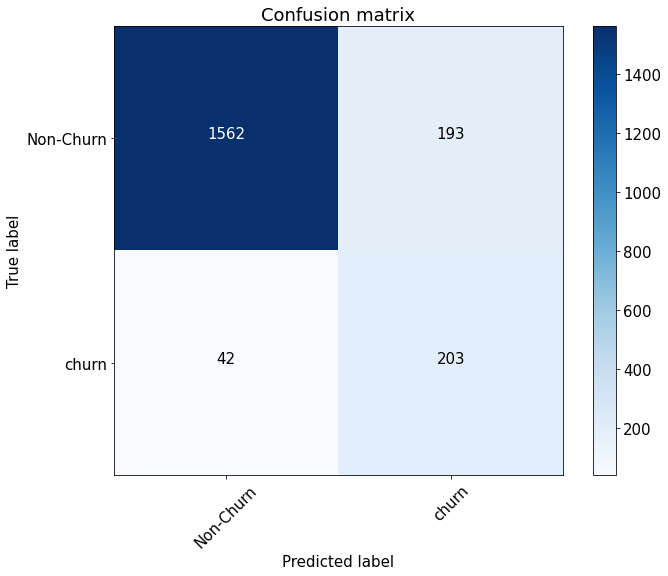

In [45]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [46]:
roc_auc_score(y_test, preds)

0.9362241990813419

В целом мы видим, что получившиеся векторные представления содержат какой-то сигнал и позволяют решать нашу прикладную задачу. 

### Домашнее задание

1. Самостоятельно разобраться с тем, что такое tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html и еще - https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)
2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)
3. Повторить п.2, но используя уже не медиану, а max
4. (опциональное, если очень хочется) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.
5. Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score
6. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

#### Ссылки

1. http://www.machinelearning.ru/wiki/images/d/d5/Voron17survey-artm.pdf
2. https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation

#### Библиотеки, которые нужно установить:

1. gensim
2. razdel
3. pymorphy2
4. nltk

# 1
Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)

In [47]:
def get_user_embedding_med(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.median(user_vector, 0)
    return user_vector

def get_user_embedding_med_df():
    user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_med(x), 1)])
    user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
    user_embeddings['uid'] = users['uid'].values
    user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
    return user_embeddings

In [48]:
user_embeddings = get_user_embedding_med_df()
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.099349,0.192814,...,0.0,0.059336,0.0,0.000000,0.0,0.0,0.000000,0.025339,0.000000,0.0
1,u108690,0.021934,0.096081,0.0,0.0,0.009848,0.0,0.000000,0.000000,0.215543,...,0.0,0.130287,0.0,0.042389,0.0,0.0,0.000000,0.088860,0.026345,0.0
2,u108339,0.020930,0.028756,0.0,0.0,0.000000,0.0,0.024089,0.077024,0.275284,...,0.0,0.099837,0.0,0.006514,0.0,0.0,0.005097,0.078212,0.083367,0.0


In [49]:
# Объединение данных по пользователям и целевой переменной

X_median = pd.merge(user_embeddings, target, 'left')
X_median.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.099349,0.192814,...,0.059336,0.0,0.000000,0.0,0.0,0.000000,0.025339,0.000000,0.0,0
1,u108690,0.021934,0.096081,0.0,0.0,0.009848,0.0,0.000000,0.000000,0.215543,...,0.130287,0.0,0.042389,0.0,0.0,0.000000,0.088860,0.026345,0.0,1
2,u108339,0.020930,0.028756,0.0,0.0,0.000000,0.0,0.024089,0.077024,0.275284,...,0.099837,0.0,0.006514,0.0,0.0,0.005097,0.078212,0.083367,0.0,1


In [50]:
# Разбивка датасета на train и test 

X_train, X_test, y_train, y_test = train_test_split(X_median[['topic_{}'.format(i) for i in range(25)]], 
                                                    X_median['churn'], random_state=0)

In [51]:
# Обучение модели
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

In [52]:
# Прогноз для тестовой выборки

preds = logreg.predict_proba(X_test)[:, 1]
preds[:5]

array([0.05233589, 0.01106119, 0.48852062, 0.23187087, 0.0555522 ])

In [53]:
# Расчет метрик 

precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.282199, F-Score=0.768, Precision=0.725, Recall=0.816


In [54]:
roc_auc = roc_auc_score(y_test, preds)
roc_auc

0.9689958718530147

In [55]:
metrics_mod_median = (fscore[ix], precision[ix], recall[ix], roc_auc)
metrics_mod_median

(0.7677543186180422,
 0.7246376811594203,
 0.8163265306122449,
 0.9689958718530147)

Confusion matrix, without normalization
[[1679   76]
 [  46  199]]


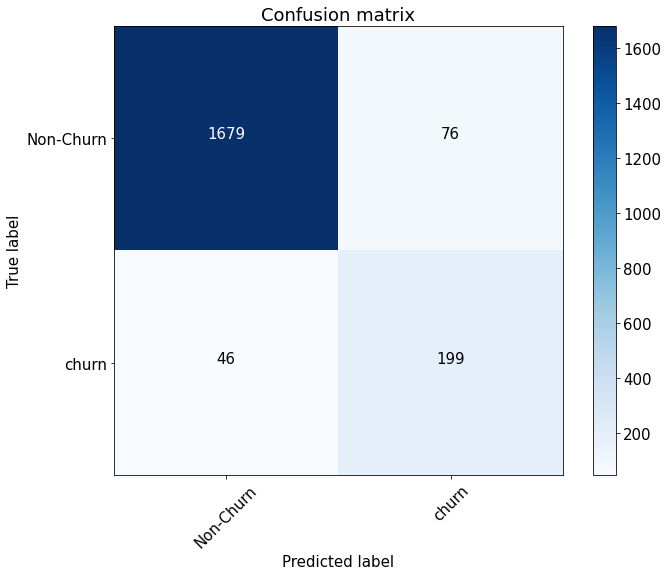

In [56]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [57]:
# Модифицированная функция, определяющая интересы пользователя исходя из прочитанных статей

def get_user_embedding_mod_max(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.max(user_vector, 0)
    return user_vector

# Модифицированная функция построения векторов

def user_embeddings_dataframe_mod_max():
    user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_mod_max(x), 1)])
    user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
    user_embeddings['uid'] = users['uid'].values
    user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]] 
    return user_embeddings

In [58]:
user_embeddings = user_embeddings_dataframe_mod_max()
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.311716,0.072883,0.103270,0.059114,0.051329,0.063487,0.043085,0.324418,0.344497,...,0.000000,0.389866,0.000000,0.000000,0.000000,0.000000,0.067090,0.296581,0.226102,0.028417
1,u108690,0.152370,0.313664,0.016978,0.023541,0.092130,0.099149,0.074130,0.178387,0.450595,...,0.000000,0.178076,0.019002,0.169055,0.000000,0.017496,0.011901,0.134943,0.173450,0.089731
2,u108339,0.131507,0.230234,0.017508,0.045558,0.018360,0.014473,0.055769,0.182601,0.350921,...,0.041526,0.185891,0.019447,0.020453,0.032984,0.000000,0.053178,0.126110,0.090191,0.087742


In [59]:
# Объединение данных по пользователям и целевой переменной

X_max = pd.merge(user_embeddings, target, 'left')
X_max.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.311716,0.072883,0.103270,0.059114,0.051329,0.063487,0.043085,0.324418,0.344497,...,0.389866,0.000000,0.000000,0.000000,0.000000,0.067090,0.296581,0.226102,0.028417,0
1,u108690,0.152370,0.313664,0.016978,0.023541,0.092130,0.099149,0.074130,0.178387,0.450595,...,0.178076,0.019002,0.169055,0.000000,0.017496,0.011901,0.134943,0.173450,0.089731,1
2,u108339,0.131507,0.230234,0.017508,0.045558,0.018360,0.014473,0.055769,0.182601,0.350921,...,0.185891,0.019447,0.020453,0.032984,0.000000,0.053178,0.126110,0.090191,0.087742,1


In [60]:
# Разбивка датасета на train и test 

X_train, X_test, y_train, y_test = train_test_split(X_max[['topic_{}'.format(i) for i in range(25)]], 
                                                    X_max['churn'], random_state=0)

In [61]:
# Обучение модели
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

In [62]:
# Прогноз для тестовой выборки

preds = logreg.predict_proba(X_test)[:, 1]
preds[:5]

array([0.05015521, 0.02042329, 0.84123408, 0.10108925, 0.00113934])

In [63]:
# Расчет метрик 

precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.363019, F-Score=0.793, Precision=0.798, Recall=0.788


In [64]:
roc_auc = roc_auc_score(y_test, preds)
roc_auc

0.9751473922902495

In [65]:
metrics_mod_max = (fscore[ix], precision[ix], recall[ix], roc_auc)
metrics_mod_max

(0.7926078028747434,
 0.7975206611570248,
 0.7877551020408163,
 0.9751473922902495)

Confusion matrix, without normalization
[[1706   49]
 [  53  192]]


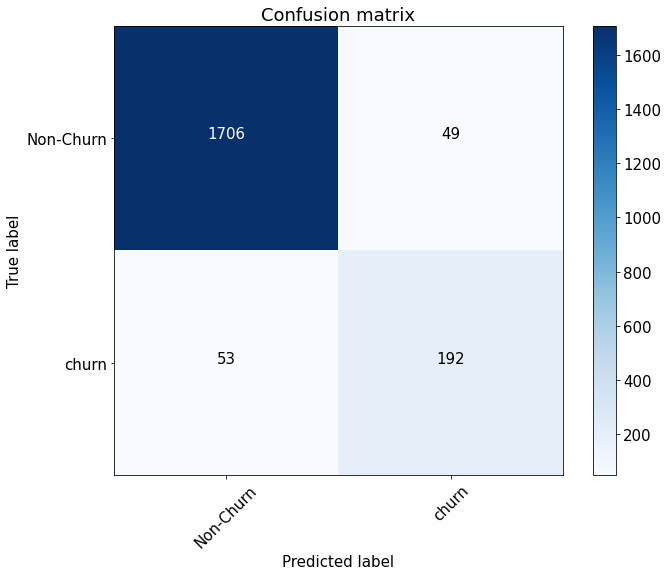

In [66]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()